# Import dataset

In [26]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("michiard/dcase-aml")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dcase-aml


In [27]:
import os
import pandas as pd

notebook_executed_in="kaggle" # or colab

if notebook_executed_in == "kaggle":
    train_dir = '/kaggle/input/dcase-aml/dev_data/dev_data/slider/train'
elif notebook_executed_in == "colab":
    train_dir = 'dcase-aml/dev_data/_dev_data/slider/train'  # TODO: verify path in Colab
else:
    raise ValueError(f"Unsupported notebook: {notebook_executed_in}")

    
# List all files in the train directory
file_names = os.listdir(train_dir)

# Optional: filter to include only certain file types (e.g., .wav, .csv, etc.)
# file_names = [f for f in file_names if f.endswith('.wav')]

# Create a DataFrame
df = pd.DataFrame(file_names, columns=['filename'])

# Display the DataFrame
df.head()

,filename
0,normal_id_02_00000546.wav
1,normal_id_02_00000764.wav
2,normal_id_00_00000530.wav
3,normal_id_02_00000820.wav
4,normal_id_02_00000102.wav


## Preprocessing : build melspectrograms from audio files

- Input : audio files in data/data
- Output : melspectrograms of size

In [28]:
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from tqdm import tqdm

## Choose the paths

In [29]:
# Enter the path to audio data
PATH_DATASET = "/kaggle/working/"
# Enter the path where spectrograms will be saved
PATH_FEATURES = PATH_DATASET+'Features/'
PATH_MELSPEC = PATH_FEATURES + 'melspec_313_128/'

## Function to build the dataframe of file names with their features for each machine type

In [30]:
# 1. Ottiene i file e assegna un'etichetta "split" (train/test)
def get_df_files(machine_str):
    path_train_folder = '/kaggle/input/dcase-aml/dev_data/dev_data/slider/train'
    path_test_folder = '/kaggle/input/dcase-aml/dev_data/dev_data/slider/test'
    
    train_files = [f for f in os.listdir(path_train_folder) if f.endswith(".wav")]
    test_files = [f for f in os.listdir(path_test_folder) if f.endswith(".wav")]

    list_dict_file = []

    for filename in train_files:
        splitted = filename.replace('.wav', '').split('_')
        list_dict_file.append({
            'filepath': os.path.join(path_train_folder, filename),
            'filename': filename,
            'status': splitted[0],
            'machine_id': f"{splitted[1]}_{splitted[2]}",
            'file_index': splitted[3],
            'split': 'train'
        })

    for filename in test_files:
        splitted = filename.replace('.wav', '').split('_')
        list_dict_file.append({
            'filepath': os.path.join(path_test_folder, filename),
            'filename': filename,
            'status': splitted[0],
            'machine_id': f"{splitted[1]}_{splitted[2]}",
            'file_index': splitted[3],
            'split': 'test'
        })

    return pd.DataFrame(list_dict_file)

## Functions to compute and save the spectograms

In [31]:
def build_melspectrogram(audio_name, spectro_params):
    #Get audio array
    audio_array, sr = librosa.load(audio_name, sr=None)

    #Get mel spectogram
    melspectrogram = librosa.feature.melspectrogram(
        y = audio_array, 
        n_fft = spectro_params['n_fft'], 
        hop_length = spectro_params['hop_length'], 
        n_mels = spectro_params['n_mels']
    )
    # Express in decibel units
    melspectrogram = librosa.power_to_db(melspectrogram, ref=1e-12)   #  ref=np.max 
    # Flatten the spectrogram
    #print("Initial Spectro shape = ", melspectrogram.shape)
    melspectrogram = melspectrogram.reshape(1, -1)
    #print("Final Spectro shape = ", melspectrogram.shape)
    
    return melspectrogram

# 2. Estrae e salva i mel-spettrogrammi separando train/test
def compute_and_save_spectros(machine_str, spectro_params):
    # Crea directory di base
    os.makedirs(PATH_FEATURES, exist_ok=True)
    os.makedirs(PATH_MELSPEC, exist_ok=True)

    # Directory train/test
    path_train_folder = os.path.join(PATH_MELSPEC, machine_str, 'train')
    path_test_folder = os.path.join(PATH_MELSPEC, machine_str, 'test')
    os.makedirs(path_train_folder, exist_ok=True)
    os.makedirs(path_test_folder, exist_ok=True)

    # Ottiene tutti i file
    df = get_df_files(machine_str)

    for _, row in df.iterrows():
        audio_path = row['filepath']
        melspectrogram = build_melspectrogram(audio_path, spectro_params)

        # Scegli percorso di salvataggio
        subfolder = path_train_folder if row['split'] == 'train' else path_test_folder
        filename = os.path.join(subfolder, row['filename'].replace('.wav', ''))

        np.save(filename, melspectrogram)

## Run it for all machine types

In [32]:
spectro_params = dict(
    n_fft = 1024,     # length of the FFT window
    hop_length = 512,    # number of samples between successive frames
    n_mels = 128       # number of Mel bands to generate
)

machines_list = ['slider']

for machine in tqdm(machines_list):
    compute_and_save_spectros(machine, spectro_params)

100%|██████████| 1/1 [01:02<00:00, 62.63s/it]


### Test

In [33]:
audio_name = '/kaggle/input/dcase-aml/dev_data/dev_data/slider/train/normal_id_00_00000000.wav'

spectro_params = dict(
    n_fft = 1024, 
    hop_length = 512, 
    n_mels=128
)

spectro = build_melspectrogram(audio_name, spectro_params)

## Plot one spectrogram for test

In [34]:
def plot_spectro(filepath):
    # Load the original melspectogram array
    spectro_array = np.load(filepath).reshape(128, 313)
    # Plot the spectrogram
    librosa.display.specshow(spectro_array, sr = 16000, x_axis = 'time', y_axis = 'mel', cmap = 'magma')

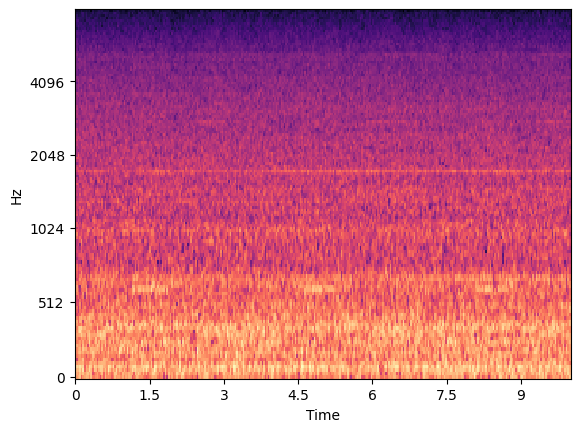

In [35]:
path = '/kaggle/working/Features/melspec_313_128/slider/train/normal_id_00_00000010.npy'
plot_spectro(path)

## Normalization

In [36]:
import os
import numpy as np

def load_all_spectrograms(folder):
    data = []
    for file in os.listdir(folder):
        if file.endswith(".npy") and "normal" in file:
            array = np.load(os.path.join(folder, file)).reshape(-1)  # Flatten per rete fully-connected
            data.append(array)
    return np.array(data)

# Sostituisci con il tuo percorso corretto
folder_path = "/kaggle/working/Features/melspec_313_128/slider/train"
X_train = load_all_spectrograms(folder_path)

print("Shape del dataset:", X_train.shape)

Shape del dataset: (2370, 40064)


In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Loading test set

In [44]:
def load_test_dataset(test_dir):
    X = []
    y = []
    filenames = []

    for fname in sorted(os.listdir(test_dir)):
        if fname.endswith(".npy"):
            fpath = os.path.join(test_dir, fname)
            x = np.load(fpath)

            # Reshape se serve
            if x.ndim == 1:
                x = x.reshape(1, -1)
            elif x.ndim == 2:
                x = x[np.newaxis, ...]

            X.append(x)
            filenames.append(fname)

            # Label dal nome file
            label = 0 if "normal" in fname.lower() else 1
            y.append(label)

    X = np.concatenate(X, axis=0)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor, filenames
test_dir = "/kaggle/working/Features/melspec_313_128/slider/test"
X_test, y_test, filenames = load_test_dataset(test_dir)
X_test = X_test.reshape(X_test.shape[0], -1)  # Da (N, 1, 128, 313) a (N, 40192)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

## Training Autoencoder

In [52]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Architettura Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# Dati e dataloader
tensor_data = torch.tensor(X_train_scaled, dtype=torch.float32)
dataset = TensorDataset(tensor_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Istanza modello
input_dim = X_train_scaled.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(30):
    total_loss = 0
    for batch in dataloader:
        x = batch[0]
        output = model(x)
        loss = criterion(output, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1, Loss: 1.0915
Epoch 2, Loss: 0.7663
Epoch 3, Loss: 0.6881
Epoch 4, Loss: 0.6566
Epoch 5, Loss: 0.6098
Epoch 6, Loss: 0.5827
Epoch 7, Loss: 0.5699
Epoch 8, Loss: 0.5631
Epoch 9, Loss: 0.5516
Epoch 10, Loss: 0.5422
Epoch 11, Loss: 0.5311
Epoch 12, Loss: 0.5231
Epoch 13, Loss: 0.5136
Epoch 14, Loss: 0.5074
Epoch 15, Loss: 0.5026
Epoch 16, Loss: 0.4935
Epoch 17, Loss: 0.4895
Epoch 18, Loss: 0.4910
Epoch 19, Loss: 0.4889
Epoch 20, Loss: 0.4856
Epoch 21, Loss: 0.4763
Epoch 22, Loss: 0.4766
Epoch 23, Loss: 0.4693
Epoch 24, Loss: 0.4664
Epoch 25, Loss: 0.4625
Epoch 26, Loss: 0.4600
Epoch 27, Loss: 0.4629
Epoch 28, Loss: 0.4615
Epoch 29, Loss: 0.4617
Epoch 30, Loss: 0.4619


## Anomaly Score Calculation

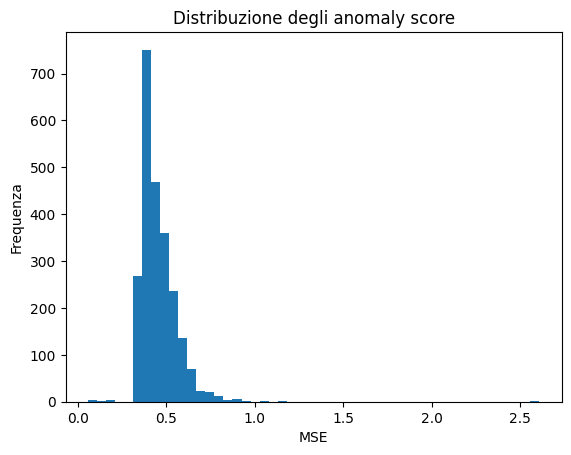

In [53]:
def anomaly_score(model, data):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(data, dtype=torch.float32)
        outputs = model(inputs)
        mse = torch.mean((outputs - inputs)**2, dim=1)
    return mse.numpy()

scores = anomaly_score(model, X_train_scaled)

# Visualizza distribuzione dei punteggi
import matplotlib.pyplot as plt
plt.hist(scores, bins=50)
plt.title("Distribuzione degli anomaly score")
plt.xlabel("MSE")
plt.ylabel("Frequenza")
plt.show()

✅ ROC AUC: 0.7041


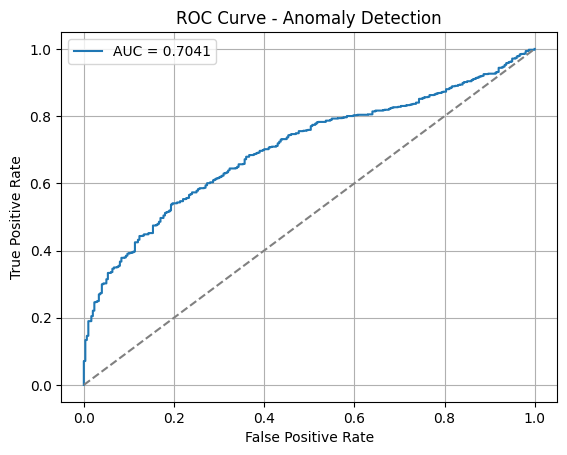

In [54]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# 🔍 3. Inferenza con autoencoder
model.eval()
with torch.no_grad():
    recon = model(X_test)

# 💥 4. Anomaly score = Mean Squared Error per esempio
reconstruction_errors = torch.mean((X_test - recon) ** 2, dim=tuple(range(1, X_test.ndim))).cpu().numpy()

# 🧠 5. Calcolo AUC ROC
auc_score = roc_auc_score(y_test.numpy(), reconstruction_errors)
print(f"✅ ROC AUC: {auc_score:.4f}")

# 📈 6. (Opzionale) Plotta curva ROC
fpr, tpr, _ = roc_curve(y_test.numpy(), reconstruction_errors)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Anomaly Detection")
plt.legend()
plt.grid(True)
plt.show()

## VAE Definition

In [55]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(256, latent_dim)
        self.logvar_layer = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar


### Loss

In [56]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


## Training VAE

In [67]:
import torch
import torch.nn as nn

def vae_loss(recon_x, x, mu, logvar, beta=0.001):
    # Ricostruzione (MSE)
    recon_loss = nn.MSELoss()(recon_x, x)
    # KL Divergence
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    # Loss totale pesata
    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss.item(), kl_div.item()

# Modello
model = VAE(input_dim=X_train_scaled.shape[1], latent_dim=8)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)

# Dataloader
dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Training
model.train()
for epoch in range(50):
    total_loss = 0
    total_rec = 0
    total_kl = 0

    for batch in dataloader:
        x = batch[0]
        recon, mu, logvar = model(x)
        loss, rec_loss, kl_loss = vae_loss(recon, x, mu, logvar, beta=0.001)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_rec += rec_loss
        total_kl += kl_loss

    avg_loss = total_loss / len(dataloader)
    avg_rec = total_rec / len(dataloader)
    avg_kl = total_kl / len(dataloader)

    scheduler.step(avg_loss)

    print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.2f} | Recon: {avg_rec:.2f} | KL: {avg_kl:.2f}")


Epoch 001 | Loss: 170282351294205.00 | Recon: 168436906989999.34 | KL: 1845447581924279.75
Epoch 002 | Loss: 13794.43 | Recon: 13663.60 | KL: 130830.32
Epoch 003 | Loss: 10991.50 | Recon: 10896.49 | KL: 95004.97
Epoch 004 | Loss: 32598.29 | Recon: 32522.37 | KL: 75926.53
Epoch 005 | Loss: 4819.66 | Recon: 4777.81 | KL: 41850.99
Epoch 006 | Loss: 2013.43 | Recon: 1975.06 | KL: 38377.98
Epoch 007 | Loss: 3445.23 | Recon: 3409.13 | KL: 36100.39
Epoch 008 | Loss: 8772.86 | Recon: 8740.20 | KL: 32658.48
Epoch 009 | Loss: 1546.14 | Recon: 1517.77 | KL: 28372.25
Epoch 010 | Loss: 2208.72 | Recon: 2181.73 | KL: 26992.29
Epoch 011 | Loss: 504.64 | Recon: 479.55 | KL: 25091.01
Epoch 012 | Loss: 4612.22 | Recon: 4587.76 | KL: 24468.68
Epoch 013 | Loss: 465.00 | Recon: 443.15 | KL: 21850.97
Epoch 014 | Loss: 2535.26 | Recon: 2514.53 | KL: 20729.44
Epoch 015 | Loss: 1828.50 | Recon: 1809.73 | KL: 18768.91
Epoch 016 | Loss: 1136.41 | Recon: 1118.43 | KL: 17980.44
Epoch 017 | Loss: 868.45 | Recon: 85

## Anomaly Score

✅ ROC AUC (recon + KL): 0.3975


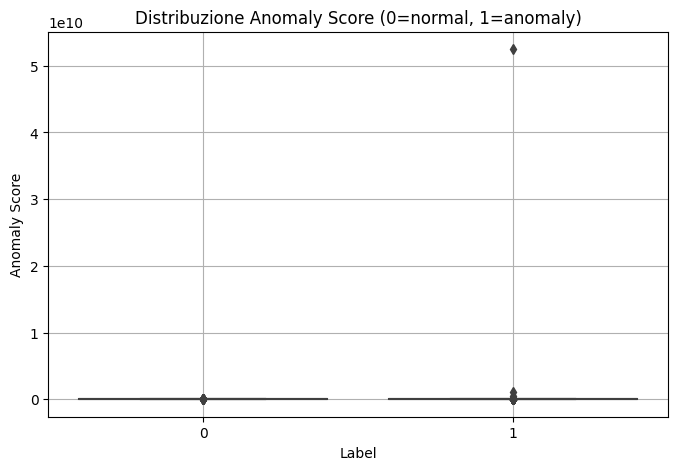

In [68]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Assicurati che il tuo modello sia in modalità eval
model.eval()

# Inference: calcolo recon, mu, logvar
with torch.no_grad():
    x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    recon, mu, logvar = model(x_test_tensor)

# Calcolo reconstruction error (MSE per sample)
recon_error = torch.mean((x_test_tensor - recon) ** 2, dim=1)

# KL divergence per sample (sommata per dimensione)
logvar = torch.clamp(logvar, min=-10, max=10)  # sicurezza
kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

# Anomaly score combinato (pesato)
alpha = 1.0  # peso per KL (puoi variare tra 0.1 e 1.0)
anomaly_score = recon_error + alpha * kl_div

# Calcolo AUC ROC
auc = roc_auc_score(y_test, anomaly_score.numpy())
print(f"✅ ROC AUC (recon + KL): {auc:.4f}")

# Boxplot della distribuzione score
df_scores = pd.DataFrame({
    'anomaly_score': anomaly_score.numpy(),
    'label': y_test.numpy()
})

plt.figure(figsize=(8, 5))
sns.boxplot(x="label", y="anomaly_score", data=df_scores)
plt.title("Distribuzione Anomaly Score (0=normal, 1=anomaly)")
plt.xlabel("Label")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.show()

## AUC-ROC VAE

In [70]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, anomaly_score)
print(f"✅ VAE ROC AUC: {auc:.4f}")


✅ VAE ROC AUC: 0.3975
